In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, auc, accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

In [ ]:
# Load PRJEB10878 data
abundance_data = pd.read_feather('abundance.feather')
meta_data = pd.read_feather('metadf.feather')

# convert the data to pandas dataframe
abundance_data = pd.DataFrame(abundance_data)
meta_data = pd.DataFrame(meta_data)

In [3]:
# print the SampleIdentifier column
# print(meta_data['SampleIdentifier'])

# Create a new DF selecting only the columns we need
new_meta_data = meta_data[['SampleIdentifier', 'config']]

In [4]:
new_meta_data = new_meta_data[new_meta_data['SampleIdentifier'] != 'ERR1018218']

# Set SampleIdentifier to the index of both DFs
abundance_data.set_index('SampleIdentifier', inplace=True)
new_meta_data.set_index('SampleIdentifier', inplace=True)

# Convert label to binary
new_meta_data['config'] = new_meta_data['config'].map({'control': 0, 'case': 1})

# print(len(abundance_data), len(new_meta_data))
new_meta_data = new_meta_data.reindex(abundance_data.index)

In [5]:
# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(abundance_data, new_meta_data['config'], test_size=0.2, 
                                                    random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

# Print the shapes of the resulting dataframes
print("Training set shape:", X_train.shape, y_train.shape)
#print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)


Training set shape: (101, 76120) (101,)
Test set shape: (26, 76120) (26,)


In [ ]:
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")

In [6]:
# Using the best parameters from grid search
best_params = {
    'max_depth': None, 
    'max_features': 'sqrt', 
    'min_samples_leaf': 4, 
    'min_samples_split': 10, 
    'n_estimators': 50,
    'random_state': 42 
}

# Create and train the model
rf_model = RandomForestClassifier(**best_params)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Predict the probabilities for the test set
y_prob = rf_model.predict_proba(X_test)[:, 1]  # Get the probability of class 1


In [7]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")

Accuracy: 0.6923076923076923
F1 Score: 0.7333333333333334
ROC AUC: 0.7976190476190476


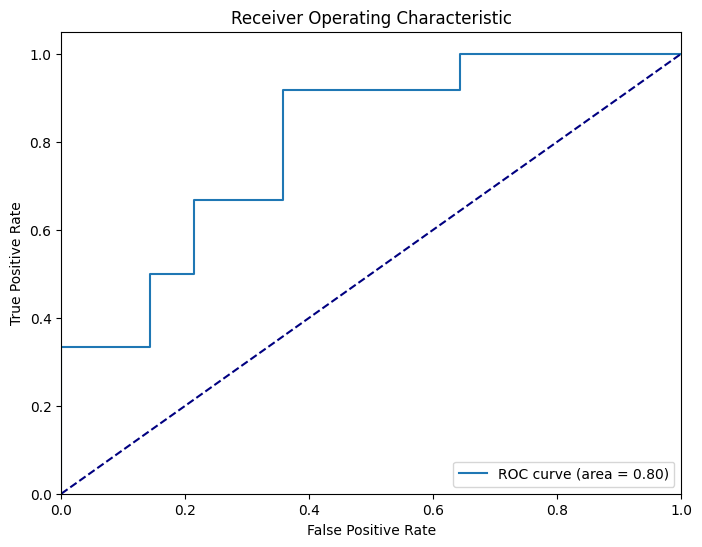

In [9]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png', dpi=300)

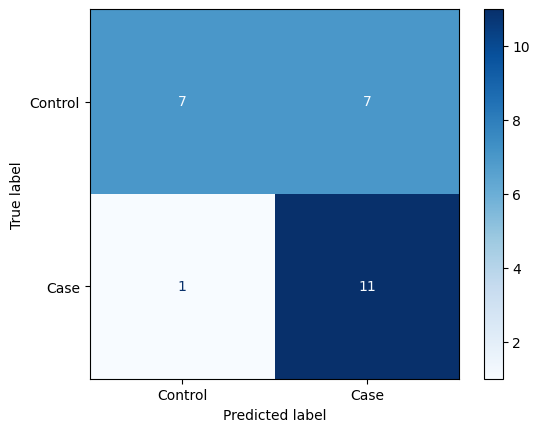

In [11]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

labels = ['Control', 'Case']


# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.savefig('confusion_matrix.png', dpi=300)

In [12]:
importances = rf_model.feature_importances_

feature_names = X_train.columns
feature_importances = pd.DataFrame({
    'feature': X_train.columns, 
    'importance': importances
})

# Sort values by importance
feature_importances.sort_values(by='importance', ascending=False, inplace=True)

print(feature_importances)

                                           feature  importance
17014              Amidase_UniRef100_UPI000E5D9DFB    0.017739
1919      DD.carboxypeptidase_UniRef100_A0A416D478    0.015407
17043  LD.carboxypeptidase_UniRef100_UPI00157001F9    0.012714
4106                  Amidase_UniRef100_A0A7I8E044    0.011796
16751  DD.carboxypeptidase_UniRef100_UPI001D066E55    0.011112
...                                            ...         ...
25506  DD.carboxypeptidase_UniRef100_UPI0012459F19    0.000000
25505     DD.carboxypeptidase_UniRef100_A0A3S5ES72    0.000000
25504              Amidase_UniRef100_UPI0015A98C79    0.000000
25503        DD.endopeptidase_UniRef100_A0A377JJH8    0.000000
76119           Muramidase_UniRef100_UPI00202504CF    0.000000

[76120 rows x 2 columns]


In [13]:
feature_importances = feature_importances.head(20)

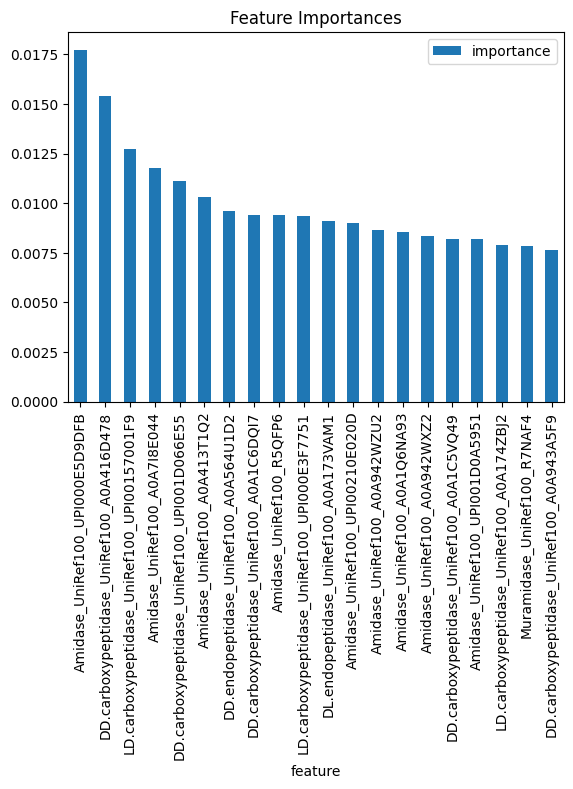

In [14]:
feature_importances.plot(kind='bar', x='feature', y='importance')
plt.title('Feature Importances')
plt.show()

In [113]:
scaler = StandardScaler()
abundance_data_scaled = scaler.fit_transform(abundance_data)

# Apply PCA
pca = PCA(n_components=2)
abundance_data_pca = pca.fit_transform(abundance_data_scaled)

# Create a DataFrame with the principal components and labels
principalDf = pd.DataFrame(data=abundance_data_pca, columns=['PC1', 'PC2'])
principalDf['Label'] = new_meta_data['config'].values

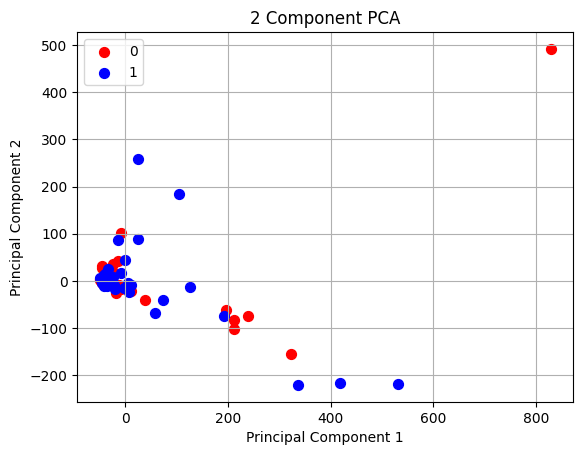

In [114]:
# Plot the principal components, colored by label
fig, ax = plt.subplots()

colors = {0: 'red', 1: 'blue'}

# Plot each label as different color
for label, color in colors.items():
    indicesToKeep = principalDf['Label'] == label
    ax.scatter(principalDf.loc[indicesToKeep, 'PC1'],
               principalDf.loc[indicesToKeep, 'PC2'],
               c=color,
               s=50)

# Label axes
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('2 Component PCA')

# Show legend
ax.legend(colors.keys())
ax.grid()

# Show plot
plt.show()

In [7]:
param_grid = {
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 500, 1000],
    'colsample_bytree': [0.3, 0.7]
}


model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           scoring='accuracy', cv=3, verbose=2)


In [ ]:
grid_search.fit(X_train, y_train)

print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")


In [15]:
final_model = xgb.XGBClassifier(
    colsample_bytree=0.7,
    learning_rate=0.1,
    max_depth=3,
    n_estimators=100,
    use_label_encoder=False, 
    eval_metric='mlogloss'
)

final_model.fit(X_train, y_train)

# Predict on the test set
y_pred = final_model.predict(X_test)


In [16]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Set: {accuracy * 100:.2f}%")

print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy on Test Set: 65.38%
              precision    recall  f1-score   support

           0       0.78      0.50      0.61        14
           1       0.59      0.83      0.69        12

    accuracy                           0.65        26
   macro avg       0.68      0.67      0.65        26
weighted avg       0.69      0.65      0.65        26

Confusion Matrix:
 [[ 7  7]
 [ 2 10]]


In [ ]:
#### READ THIS ####
# Rather thank identifying important individual enzyme, should be looking at which clusters are
# Over-represented in the traits that we want, and those that we dont want. After analysis, should
# cluster the enzymes and investigate this. Need to make clusters and pull reps for each of the enzyme 
# types. 

